In [17]:
import numpy as np
import scipy.io.wavfile as wave_io
import matplotlib.pyplot as plt
import librosa
import librosa.display
from pydub import AudioSegment
import warnings
from scipy.signal import butter, lfilter, filtfilt
warnings.filterwarnings('ignore')

def enhance_audio_signal(raw_data, fs):
    """
    Enhanced audio signal processing with customized filtering.
    """
    # Handle stereo to mono conversion
    if len(raw_data.shape) > 1:
        raw_data = raw_data.mean(axis=1)
    
    # Normalize and convert to float32
    audio_norm = raw_data.astype(np.float32)
    audio_norm = audio_norm / np.max(np.abs(audio_norm))
    
    # Remove DC bias
    audio_norm = audio_norm - np.mean(audio_norm)
    
    # Apply emphasis filter
    emphasis_factor = 0.95
    audio_norm = np.append(audio_norm[0], audio_norm[1:] - emphasis_factor * audio_norm[:-1])
    
    # Speech-optimized bandpass filter (50Hz-10000Hz)
    nyq = fs / 2
    freq_low = 50 / nyq
    freq_high = 10000 / nyq
    filter_coeffs = butter(2, [freq_low, freq_high], btype='band')
    audio_norm = filtfilt(filter_coeffs[0], filter_coeffs[1], audio_norm)
    
    return audio_norm

def transform_audio_format(src_path, dest_path='processed_audio.wav'):
    """
    Audio format conversion with enhanced error handling.
    """
    try:
        print(f"Processing {src_path}...")
        audio_data = AudioSegment.from_file(src_path, format='m4a')
        
        # Standardize audio parameters
        audio_data = audio_data.set_channels(1)
        audio_data = audio_data.set_frame_rate(44100)
        audio_data = audio_data.set_sample_width(2)
        
        audio_data.export(dest_path, format='wav')
        
        fs, raw_data = wave_io.read(dest_path)
        enhanced_signal = enhance_audio_signal(raw_data, fs)
        
        print(f"Audio processed successfully at {fs} Hz")
        return fs, enhanced_signal
    
    except Exception as e:
        print(f"Processing error: {e}")
        return None, None

def visualize_time_frequency(signal_data, fs, prefix=""):
    """
    Generate enhanced spectrograms with custom color schemes.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Detailed spectrogram (narrow-band)
    ax1.specgram(signal_data, NFFT=2048, Fs=fs, 
                noverlap=1024, cmap='magma')
    ax1.set_title(f'{prefix} Detailed Frequency Analysis')
    ax1.set_xlabel('Duration (s)')
    ax1.set_ylabel('Frequency (Hz)')
    
    # Overview spectrogram (wide-band)
    ax2.specgram(signal_data, NFFT=512, Fs=fs, 
                noverlap=384, cmap='plasma')
    ax2.set_title(f'{prefix} Overview Frequency Analysis')
    ax2.set_xlabel('Duration (s)')
    ax2.set_ylabel('Frequency (Hz)')
    
    plt.tight_layout()
    plt.show()

def analyze_fundamental_frequency(signal_data, fs):
    """
    Advanced pitch analysis using YIN and AMD methods.
    """
    frame_size = 2048
    hop_size = 512
    min_freq = 60
    max_freq = 200
    
    # Apply center clipping
    clip_threshold = 0.3 * np.max(np.abs(signal_data))
    processed_signal = np.where(np.abs(signal_data) < clip_threshold, 0, signal_data)
    
    # Primary pitch detection (YIN)
    f0, voiced_flags, confidence = librosa.pyin(
        processed_signal,
        fmin=min_freq,
        fmax=max_freq,
        sr=fs,
        frame_length=frame_size,
        hop_length=hop_size,
        center=True,
        pad_mode='reflect'
    )
    
    # Secondary pitch detection (AMD)
    def compute_pitch_amd(frame):
        """
        Average Magnitude Difference Function for pitch detection.
        """
        frame_length = len(frame)
        max_lag = min(frame_length - 1, int(fs / min_freq))
        min_lag = max(1, int(fs / max_freq))
        
        amd = np.zeros(max_lag)
        for lag in range(min_lag, max_lag):
            # Calculate AMD for current lag
            diff = np.abs(frame[lag:] - frame[:-lag])
            amd[lag] = np.mean(diff)
        
        # Find the first strong minimum after min_lag
        # Normalize AMD values
        amd_norm = amd[min_lag:] / (np.max(amd[min_lag:]) + 1e-8)
        valleys = np.where((amd_norm[1:-1] < amd_norm[:-2]) & 
                         (amd_norm[1:-1] < amd_norm[2:]))[0] + 1
        
        if len(valleys) > 0:
            best_lag = valleys[0] + min_lag
            return fs / best_lag
        return None
    
    # Frame processing
    frames = librosa.util.frame(processed_signal, 
                               frame_length=frame_size, 
                               hop_length=hop_size)
    
    amd_results = []
    for frame in frames.T:
        pitch = compute_pitch_amd(frame)
        if pitch and min_freq <= pitch <= max_freq:
            amd_results.append(pitch)
    
    # Combine and filter results
    valid_pitches = []
    for idx, pitch in enumerate(f0):
        if voiced_flags[idx] and pitch and min_freq <= pitch <= max_freq:
            valid_pitches.append(pitch)
    
    if valid_pitches:
        valid_pitches = np.array(valid_pitches)
        filtered_pitches = np.median(
            librosa.util.frame(valid_pitches, 
                             frame_length=5, 
                             hop_length=1), 
            axis=0
        )
        
        # Statistical analysis
        pitch_mean = np.mean(filtered_pitches)
        pitch_median = np.median(filtered_pitches)
        pitch_std = np.std(filtered_pitches)
        
        # Visualization
        plt.figure(figsize=(12, 6))
        
        # YIN results
        plt.subplot(211)
        time_points = librosa.times_like(filtered_pitches, sr=fs, hop_length=hop_size)
        plt.plot(time_points, filtered_pitches, color='darkred', label='Pitch Contour', alpha=0.7)
        plt.axhline(y=pitch_mean, color='gold', linestyle='--', label='Mean Pitch')
        plt.fill_between(time_points, 
                        filtered_pitches - pitch_std, 
                        filtered_pitches + pitch_std, 
                        alpha=0.2, 
                        color='coral')
        plt.title('YIN Pitch Analysis')
        plt.ylabel('Frequency (Hz)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # AMD results
        if amd_results:
            plt.subplot(212)
            amd_times = np.arange(len(amd_results)) * hop_size / fs
            plt.plot(amd_times, amd_results, color='darkgreen', label='AMD Analysis', alpha=0.7)
            plt.axhline(y=np.median(amd_results), color='gold', linestyle='--', label='Median AMD')
            plt.title('AMD Pitch Analysis')
            plt.xlabel('Time (s)')
            plt.ylabel('Frequency (Hz)')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return {
            'mean': pitch_mean,
            'median': pitch_median,
            'std': pitch_std,
            'amd_median': np.median(amd_results) if amd_results else None
        }
    return None

def extract_formants(signal_data, fs):
    """
    Enhanced formant extraction using LPC analysis.
    """
    window_duration = int(0.025 * fs)
    step_size = int(0.01 * fs)
    frame_count = 1 + (len(signal_data) - window_duration) // step_size
    
    formant_tracks = []
    
    for i in range(frame_count):
        start_idx = i * step_size
        end_idx = start_idx + window_duration
        frame = signal_data[start_idx:end_idx]
        
        # Window application
        frame = frame * np.hamming(len(frame))
        
        # LPC computation
        lpc_order = int(2 + fs / 1000)
        lpc_coefficients = librosa.lpc(frame, order=lpc_order)
        
        # Root analysis
        roots = np.roots(lpc_coefficients)
        roots = roots[np.imag(roots) >= 0]
        
        # Frequency conversion
        frequencies = np.angle(roots) * (fs / (2 * np.pi))
        
        # Filter and sort
        valid_formants = sorted(frequencies[(frequencies > 90) & (frequencies < 5000)])
        
        if len(valid_formants) >= 3:
            formant_tracks.append(valid_formants[:3])
    
    if formant_tracks:
        formant_data = np.array(formant_tracks)
        mean_formants = np.mean(formant_data, axis=0)
        
        # Visualization
        plt.figure(figsize=(12, 4))
        colors = ['darkred', 'darkgreen', 'darkblue']
        for i in range(3):
            plt.plot(formant_data[:, i], color=colors[i], label=f'Formant {i+1}')
        plt.title('Formant Frequency Analysis')
        plt.xlabel('Frame Index')
        plt.ylabel('Frequency (Hz)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        return mean_formants
    return None

def analyze_cepstrum(signal_data, fs):
    """
    Advanced cepstral analysis with enhanced visualization.
    """
    # Cepstrum computation
    spectrum = np.fft.fft(signal_data)
    log_spectrum = np.log(np.abs(spectrum) + 1e-10)
    cepstrum = np.fft.ifft(log_spectrum).real
    
    # Visualization
    plt.figure(figsize=(12, 4))
    time_scale = np.arange(len(cepstrum)) / fs * 1000
    plt.plot(time_scale[:len(cepstrum)//2], cepstrum[:len(cepstrum)//2], 
             color='darkviolet', alpha=0.7)
    plt.title('Cepstral Analysis')
    plt.xlabel('Quefrency (ms)')
    plt.ylabel('Magnitude')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Pitch estimation
    min_period = int(fs / 500)
    max_period = int(fs / 50)
    fundamental_period = min_period + np.argmax(cepstrum[min_period:max_period])
    
    return fs / fundamental_period

def analyze_frame_cepstra(signal_data, fs, frame_count=10):
    """
    Frame-by-frame cepstral analysis with visualization.
    """
    window_size = int(0.025 * fs)
    step_size = int(0.01 * fs)

    frames = librosa.util.frame(signal_data, frame_length=window_size, hop_length=step_size).T

    fig, axes = plt.subplots(frame_count, 1, figsize=(12, 2 * frame_count))
    
    colors = plt.cm.viridis(np.linspace(0, 1, frame_count))
    
    for i in range(frame_count):
        frame = frames[i]
        spectrum = np.fft.fft(frame)
        log_spectrum = np.log(np.abs(spectrum) + 1e-10)
        cepstrum = np.fft.ifft(log_spectrum).real
        
        time_scale = np.arange(len(cepstrum)) / fs * 1000
        axes[i].plot(time_scale[:len(cepstrum)//2], cepstrum[:len(cepstrum)//2], 
                    color=colors[i])
        axes[i].set_title(f'Frame {i+1} Cepstrum')
        axes[i].set_xlabel('Quefrency (ms)')
        axes[i].set_ylabel('Magnitude')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def comprehensive_voice_analysis(audio_path):
    """
    Complete voice analysis pipeline with enhanced visualization.
    """
    fs, signal_data = transform_audio_format(audio_path)
    if signal_data is None:
        return
    
    print("\n=== Acoustic Analysis Results ===")
    
    # Spectrogram analysis
    visualize_time_frequency(signal_data, fs, audio_path)
    
    # Pitch analysis
    pitch_data = analyze_fundamental_frequency(signal_data, fs)
    if pitch_data:
        print(f"\nPitch Characteristics:")
        print(f"Mean: {pitch_data['mean']:.1f} Hz")
        print(f"Median: {pitch_data['median']:.1f} Hz")
        print(f"Standard Deviation: {pitch_data['std']:.1f} Hz")
    
    # Formant analysis
    formant_data = extract_formants(signal_data, fs)
    if formant_data is not None:
        print(f"\nFormant Frequencies:")
        print(f"F1: {formant_data[0]:.1f} Hz")
        print(f"F2: {formant_data[1]:.1f} Hz")
        print(f"F3: {formant_data[2]:.1f} Hz")
    
    # Cepstral analysis
    cepstral_pitch = analyze_cepstrum(signal_data, fs)
    print(f"\nCepstral Analysis:")
    print(f"Estimated pitch: {cepstral_pitch:.1f} Hz")
    
    print("\nGenerating frame-wise cepstral analysis...")
    analyze_frame_cepstra(signal_data, fs, frame_count=6)

=== Voice Analysis System ===
Processing 3 audio files...


Analyzing file: aa.m4a
Processing /kaggle/input/soundfiles/aa.m4a...
Audio processed successfully at 44100 Hz

=== Acoustic Analysis Results ===


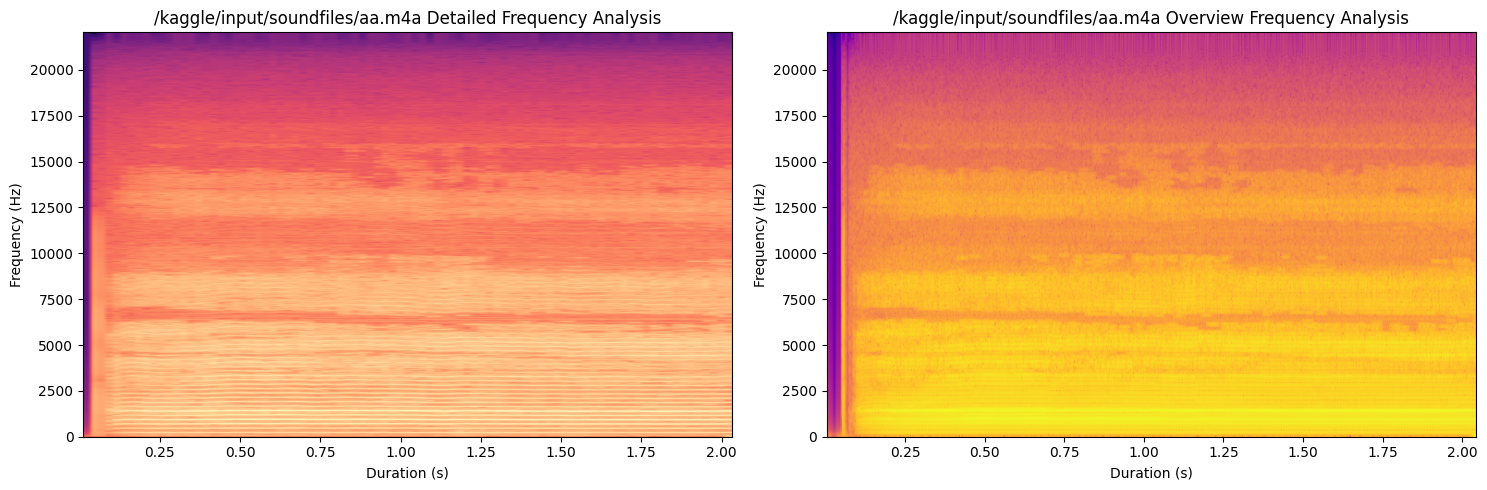

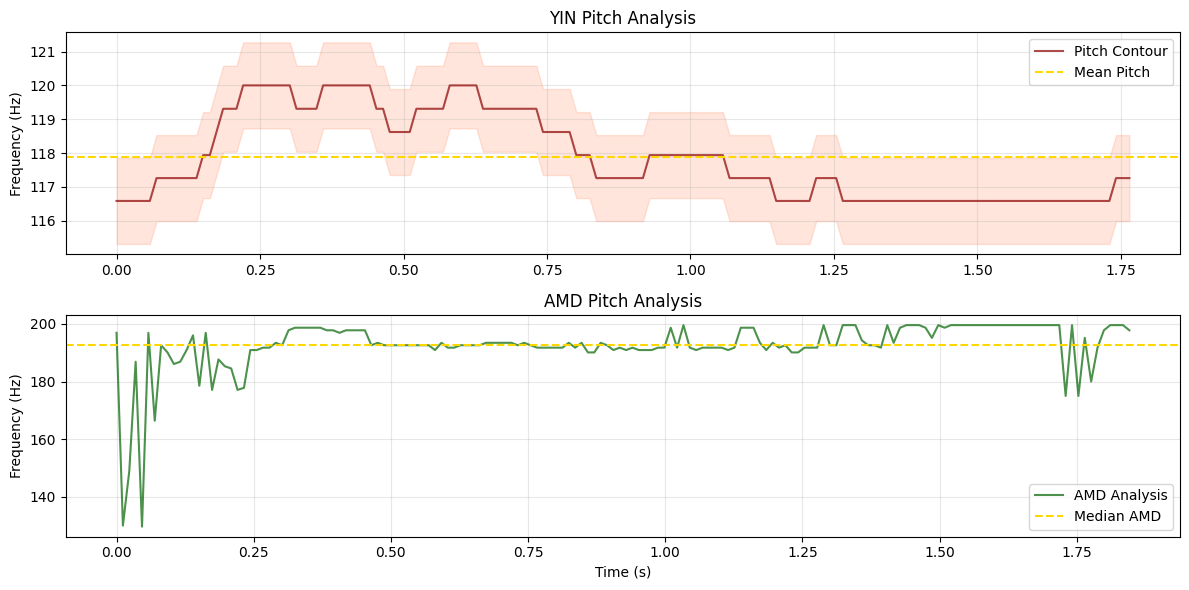


Pitch Characteristics:
Mean: 117.9 Hz
Median: 117.3 Hz
Standard Deviation: 1.3 Hz


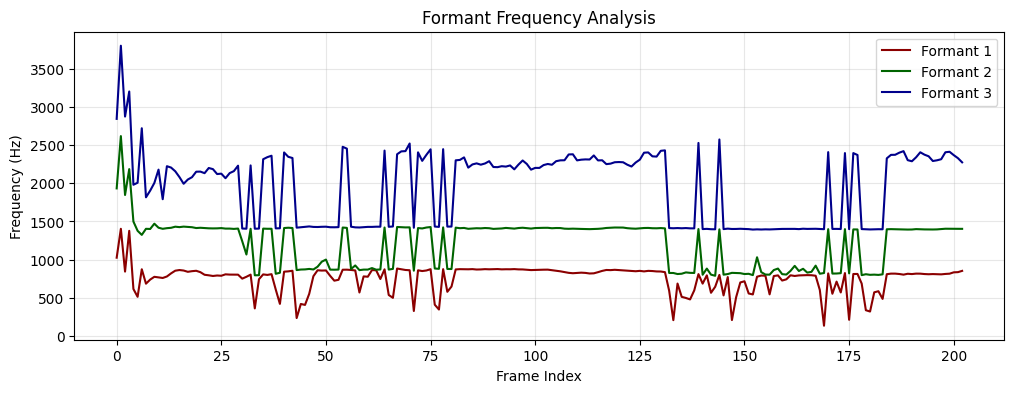


Formant Frequencies:
F1: 759.0 Hz
F2: 1211.2 Hz
F3: 1963.3 Hz


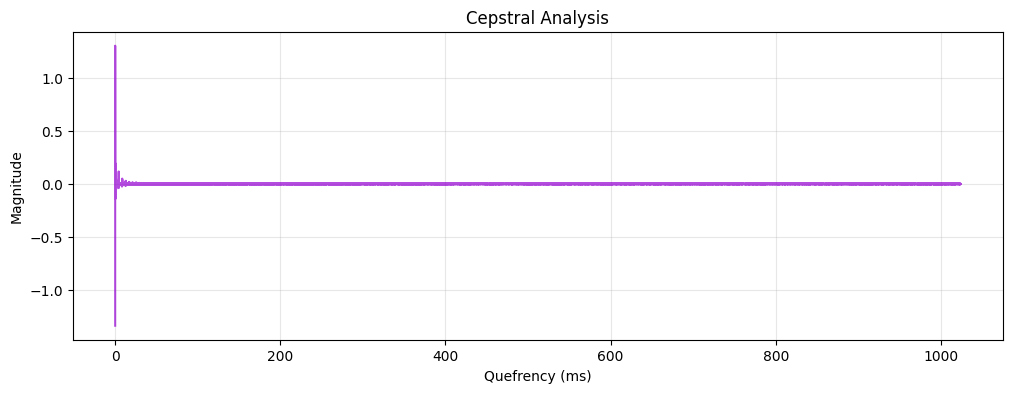


Cepstral Analysis:
Estimated pitch: 234.6 Hz

Generating frame-wise cepstral analysis...


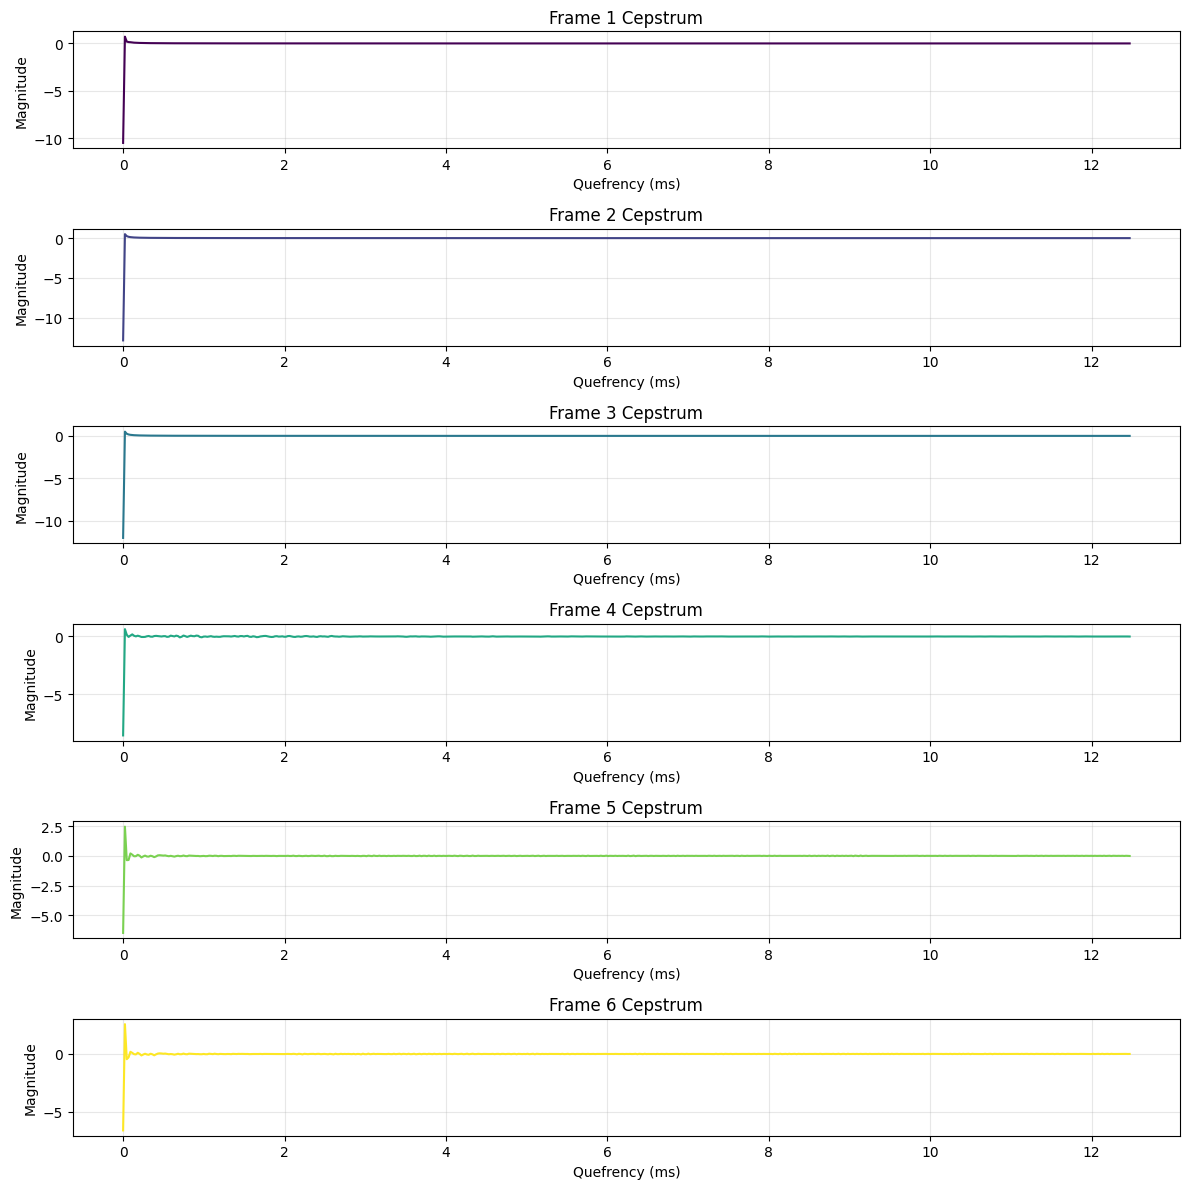

Processed audio saved to: analysis_results/aa.wav

Analyzing file: ii.m4a
Processing /kaggle/input/soundfiles/ii.m4a...
Audio processed successfully at 44100 Hz

=== Acoustic Analysis Results ===


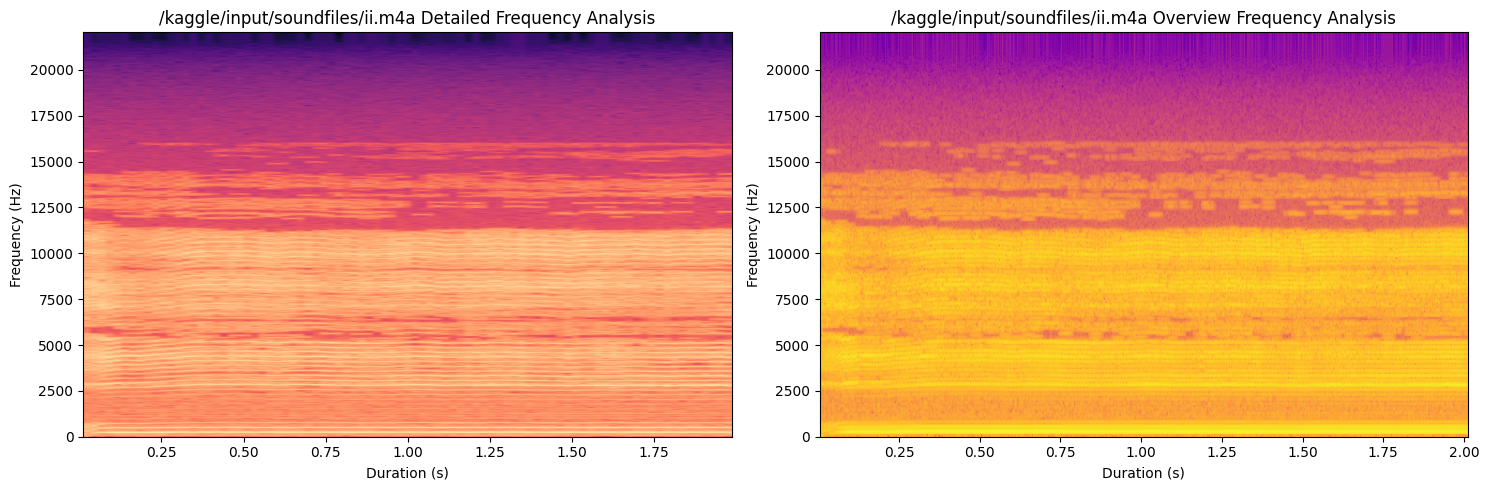

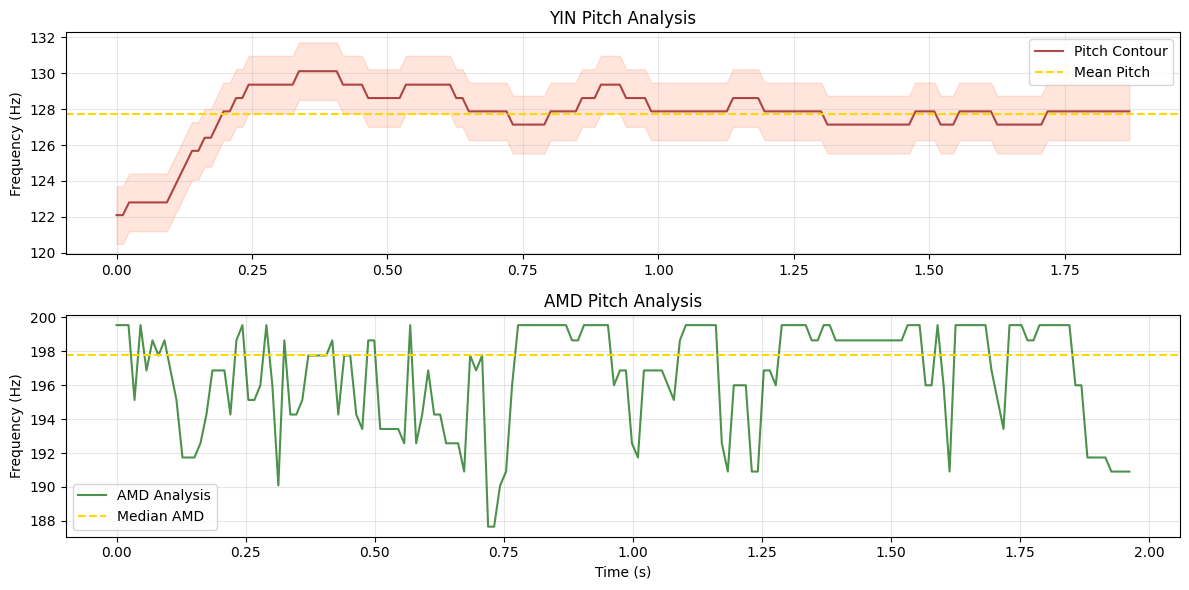


Pitch Characteristics:
Mean: 127.7 Hz
Median: 127.9 Hz
Standard Deviation: 1.6 Hz


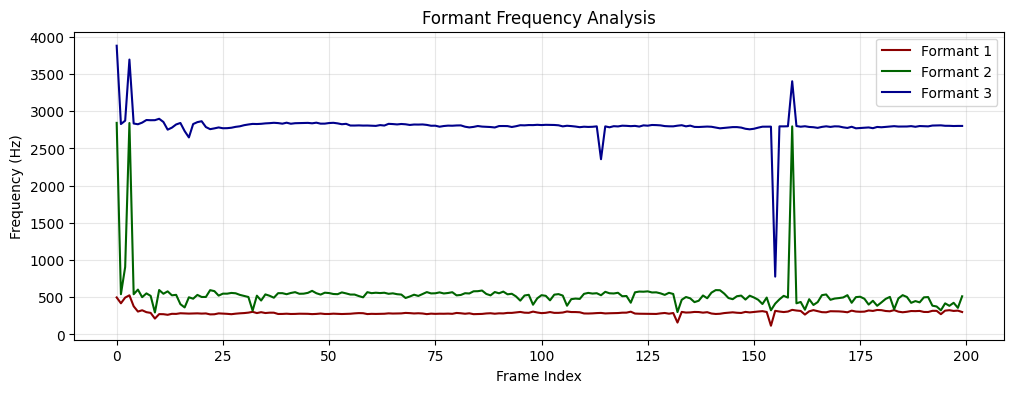


Formant Frequencies:
F1: 293.7 Hz
F2: 544.4 Hz
F3: 2805.9 Hz


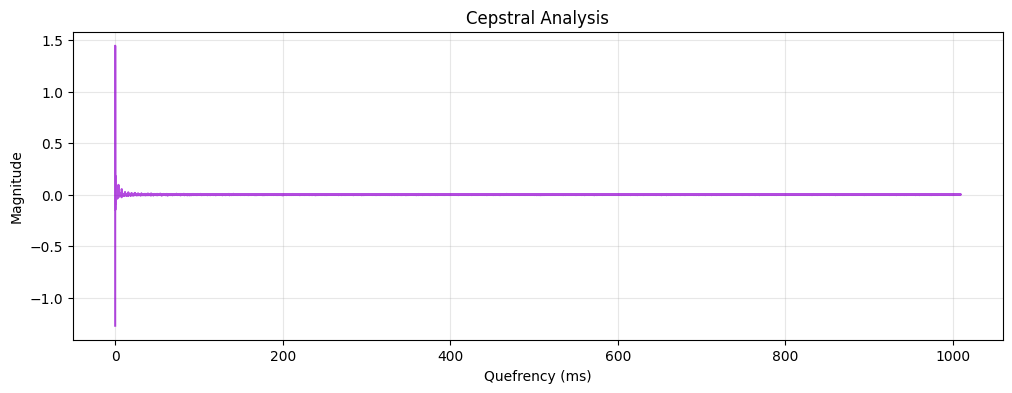


Cepstral Analysis:
Estimated pitch: 254.9 Hz

Generating frame-wise cepstral analysis...


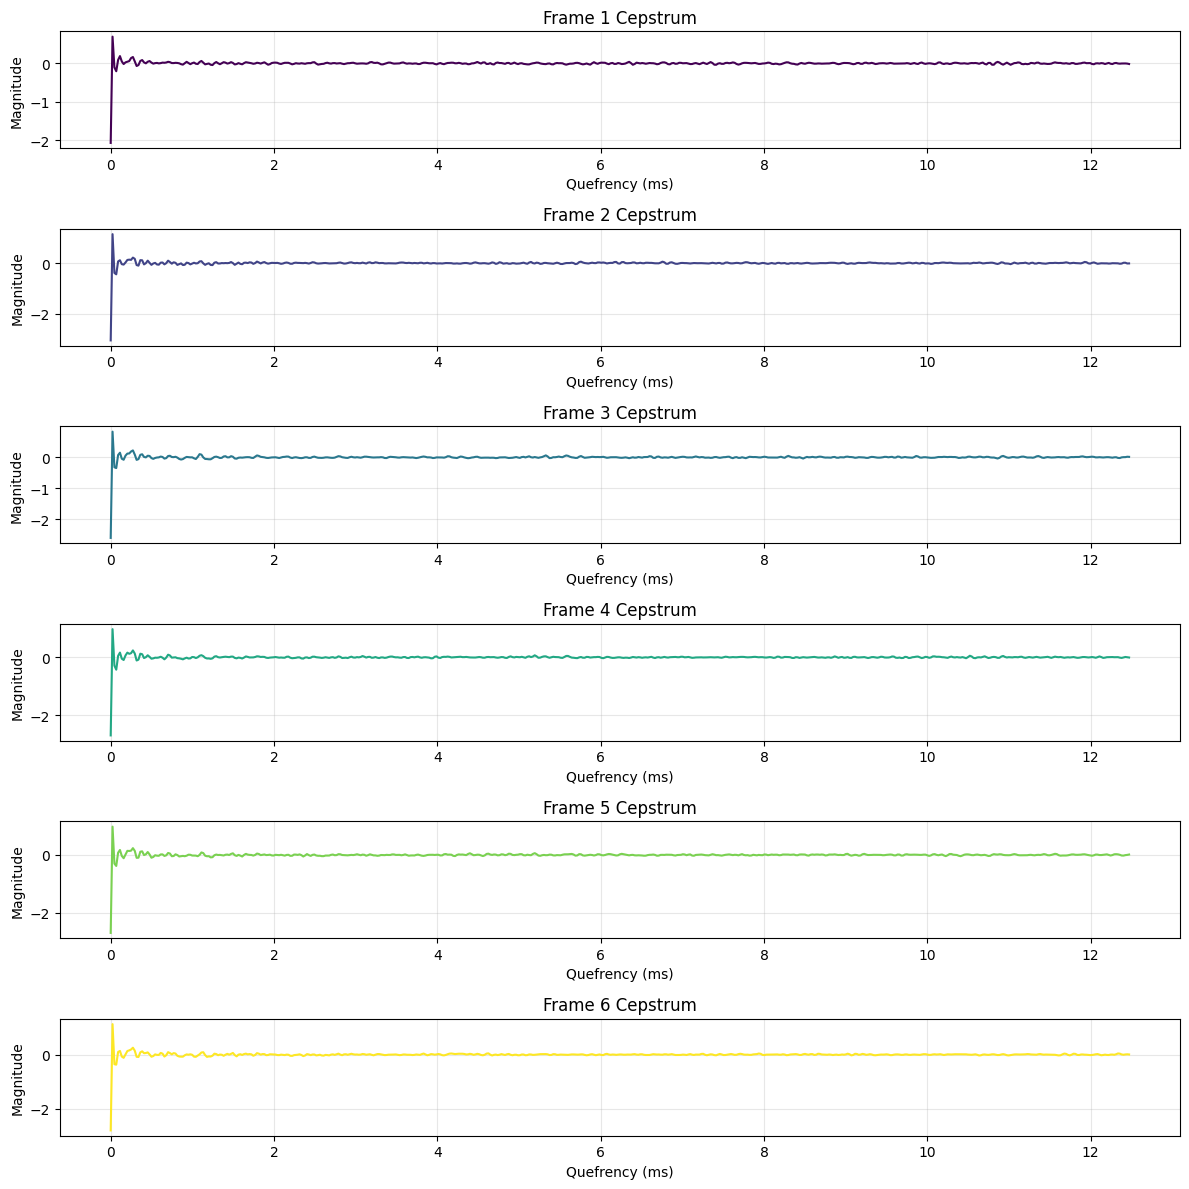

Processed audio saved to: analysis_results/ii.wav

Analyzing file: uu.m4a
Processing /kaggle/input/soundfiles/uu.m4a...
Audio processed successfully at 44100 Hz

=== Acoustic Analysis Results ===


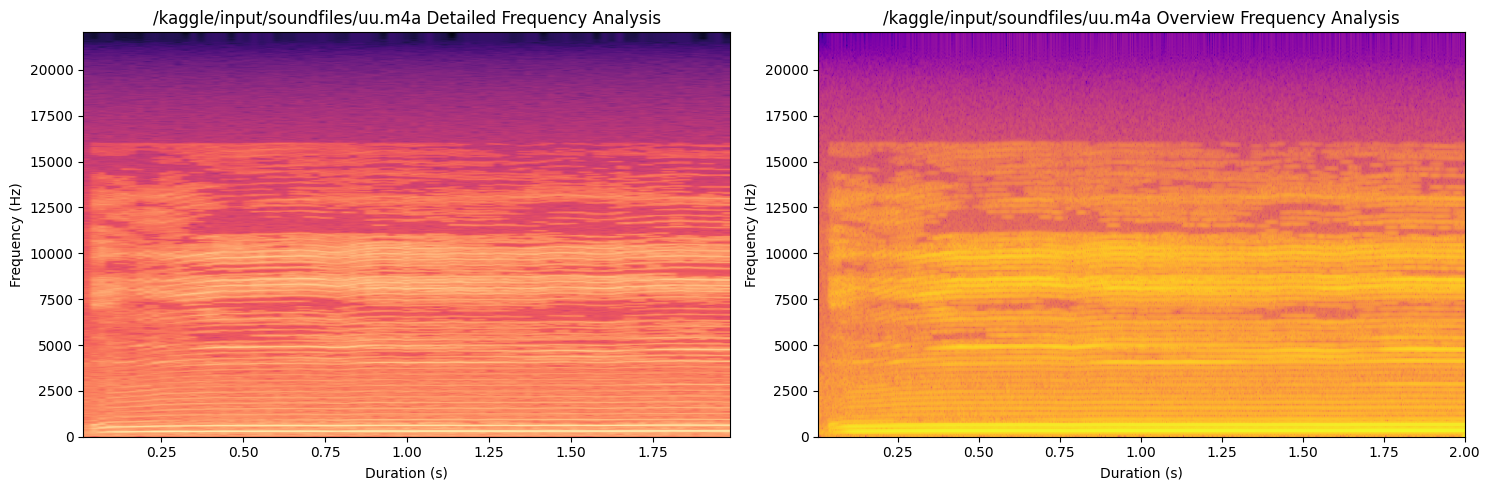

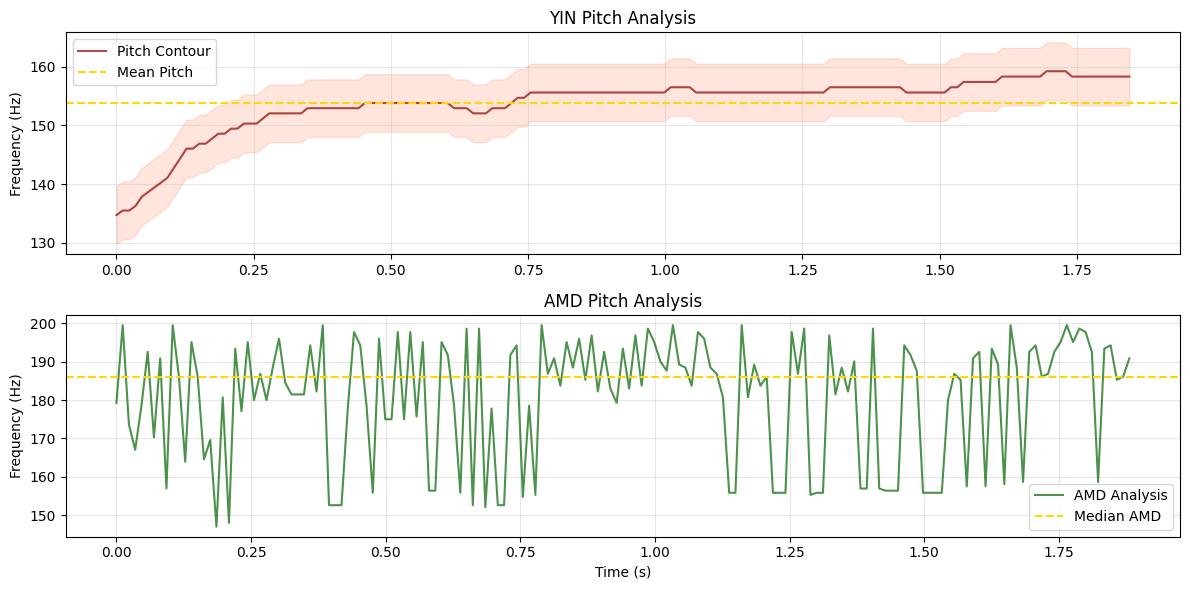


Pitch Characteristics:
Mean: 153.8 Hz
Median: 155.6 Hz
Standard Deviation: 4.9 Hz


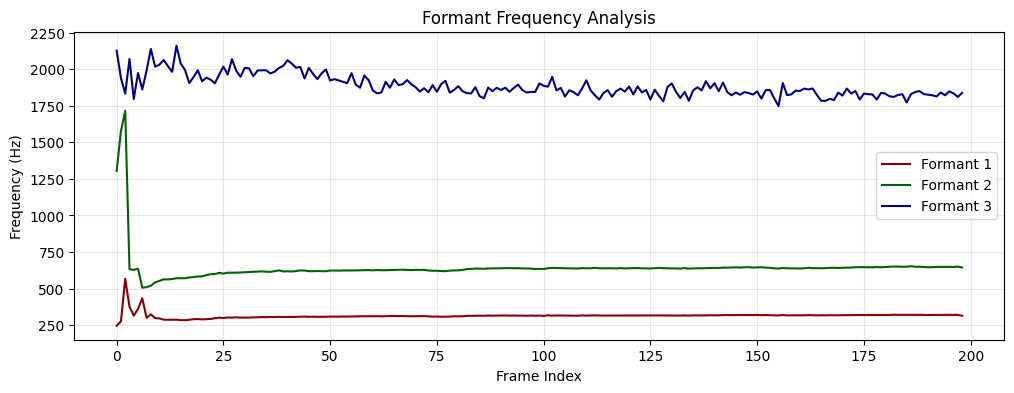


Formant Frequencies:
F1: 314.2 Hz
F2: 641.7 Hz
F3: 1886.9 Hz


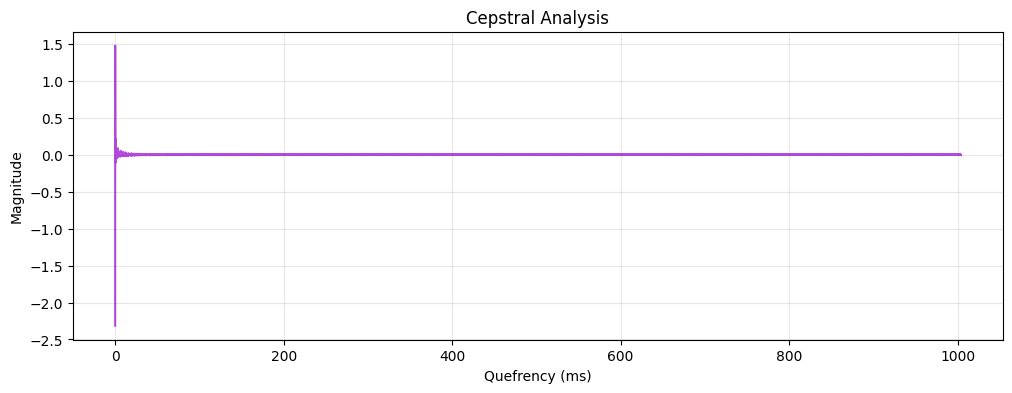


Cepstral Analysis:
Estimated pitch: 312.8 Hz

Generating frame-wise cepstral analysis...


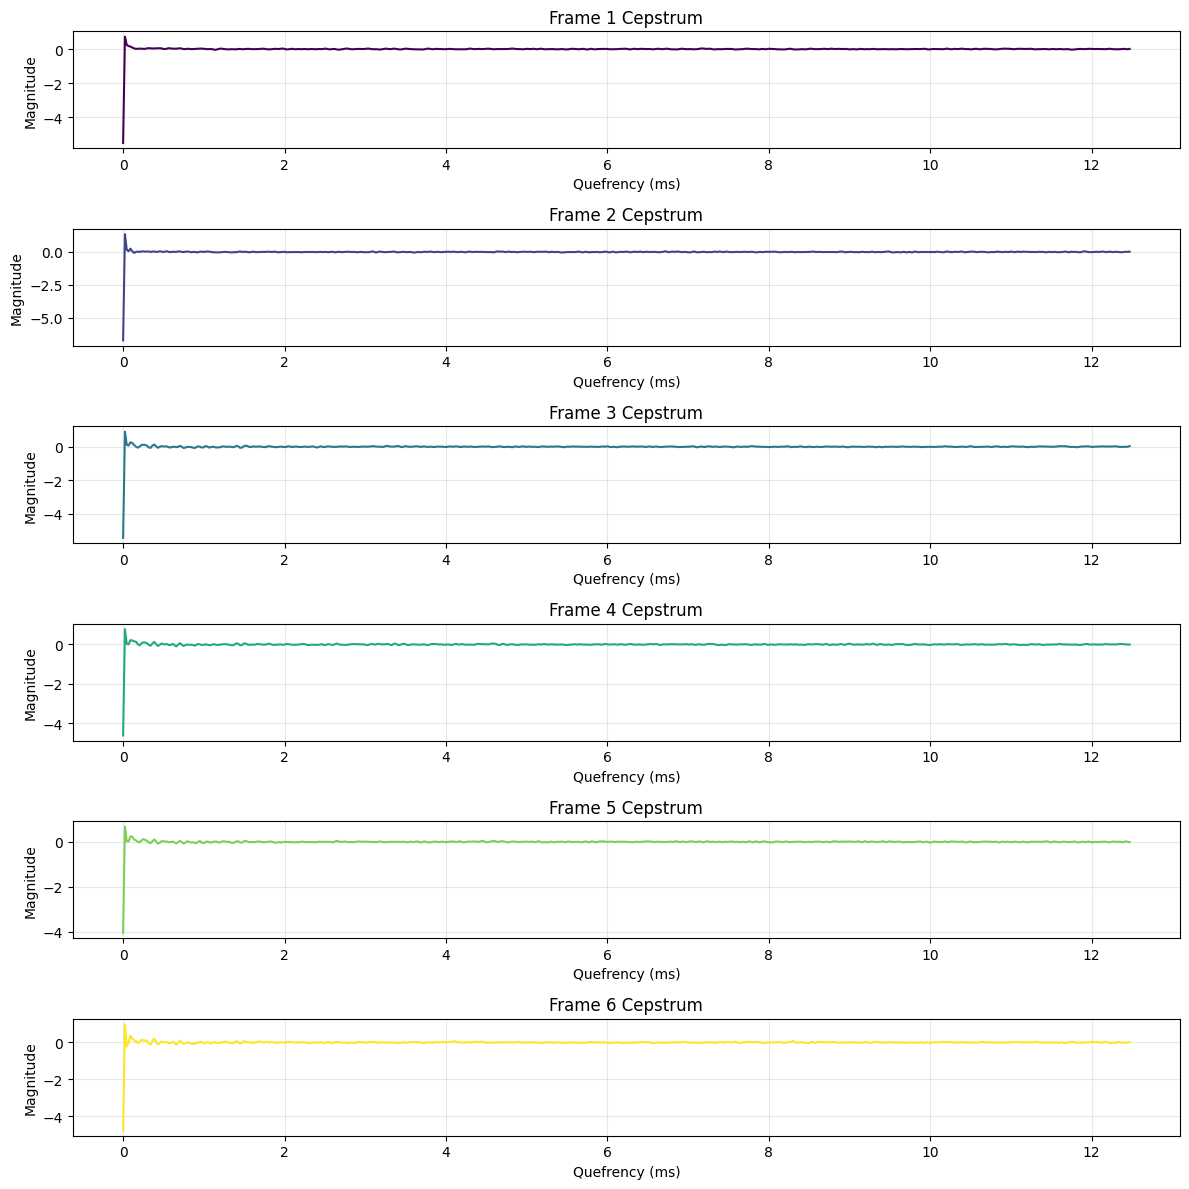

Processed audio saved to: analysis_results/uu.wav

Analysis complete!


In [18]:
# List of audio files to analyze
audio_files = [
    "/kaggle/input/soundfiles/aa.m4a",
    "/kaggle/input/soundfiles/ii.m4a",
    "/kaggle/input/soundfiles/uu.m4a"
]

# Main execution block
if __name__ == "__main__":
    print("=== Voice Analysis System ===")
    print(f"Processing {len(audio_files)} audio files...\n")
    
    # Create results directory if it doesn't exist
    import os
    results_dir = "analysis_results"
    os.makedirs(results_dir, exist_ok=True)
    
    # Process each audio file
    for audio_file in audio_files:
        print(f"\nAnalyzing file: {os.path.basename(audio_file)}")
        try:
            # Run comprehensive analysis
            comprehensive_voice_analysis(audio_file)
            
            # Save the processed audio file
            output_wav = os.path.join(results_dir, 
                                    f"{os.path.splitext(os.path.basename(audio_file))[0]}.wav")
            print(f"Processed audio saved to: {output_wav}")
            
        except Exception as e:
            print(f"Error processing {audio_file}: {str(e)}")
            continue
    
    print("\nAnalysis complete!")